In [1]:
# Import library yang diperlukan
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mediapipe as mp
from scipy.spatial import distance
import os
import random
import matplotlib.pyplot as plt

3. Load Gambar

Total frame yang diekstrak: 652


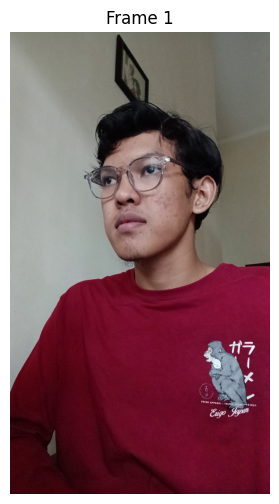

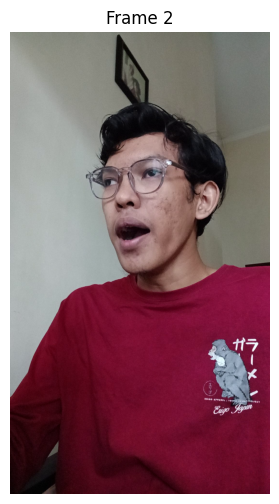

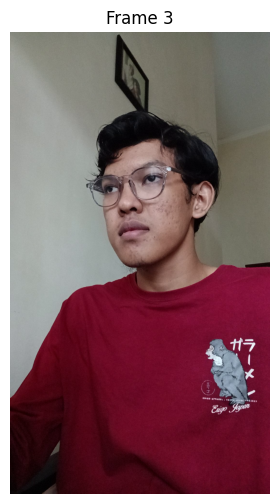

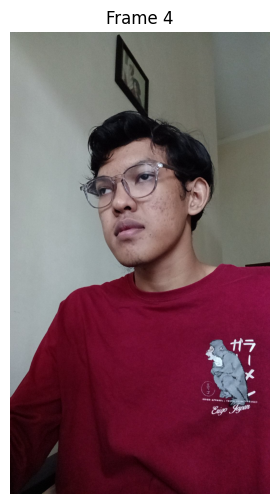

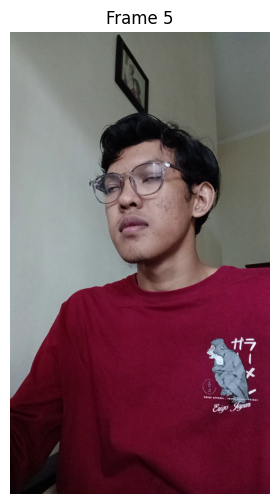

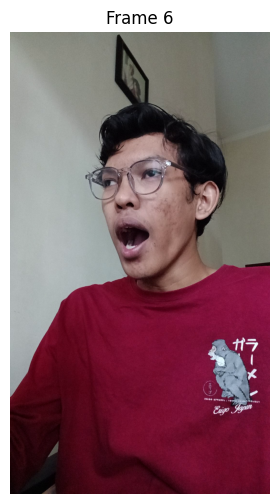

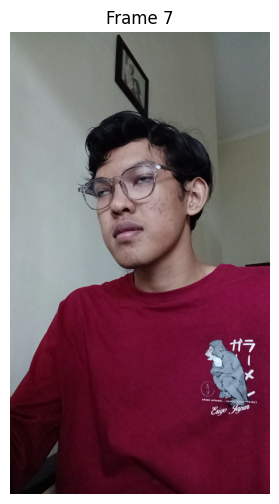

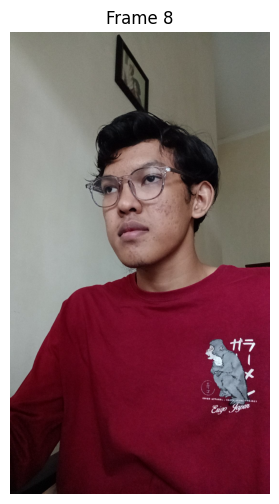

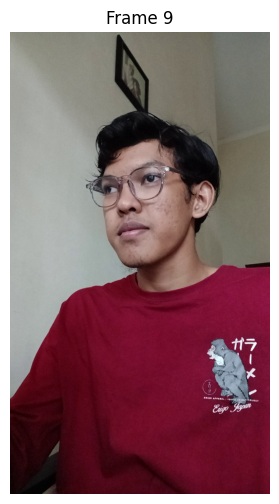

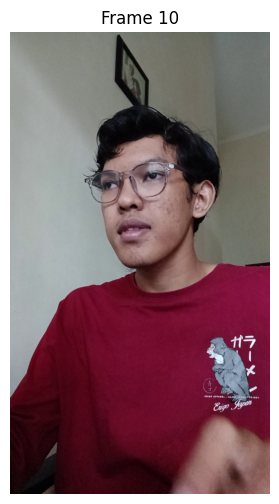

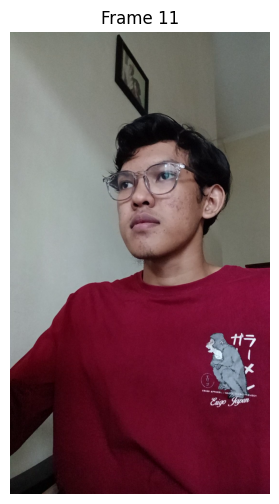

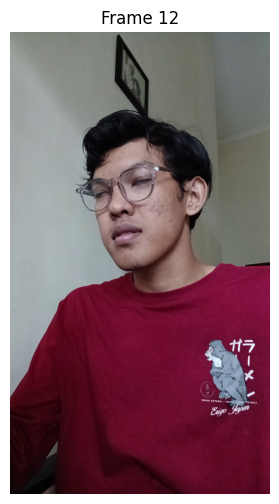

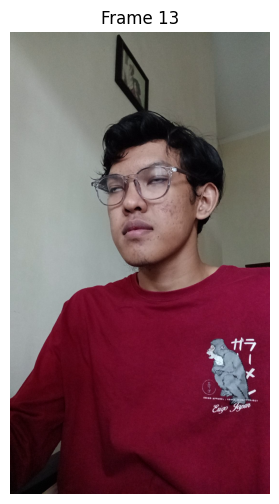

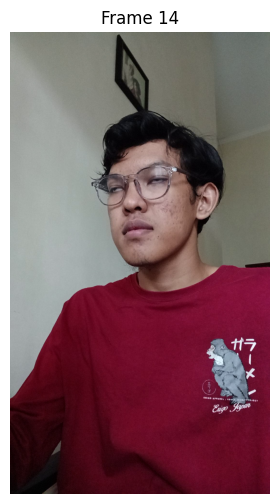

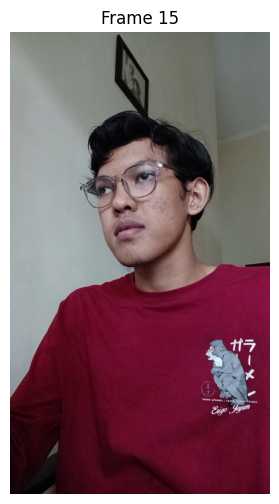

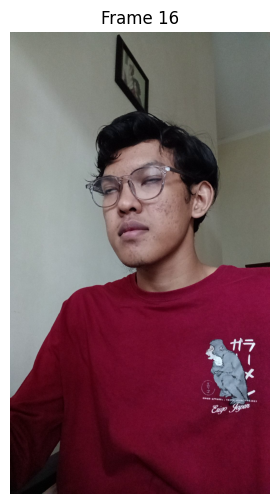

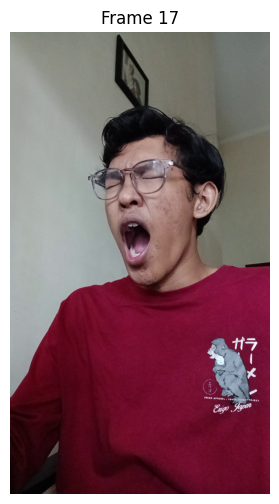

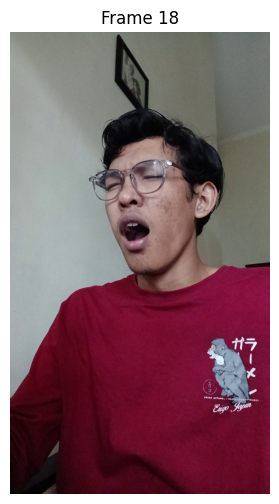

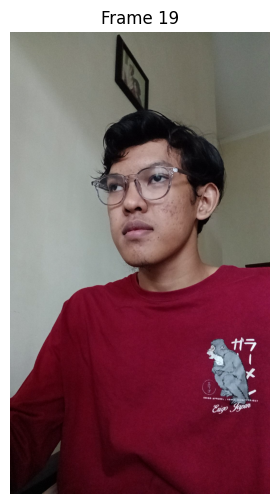

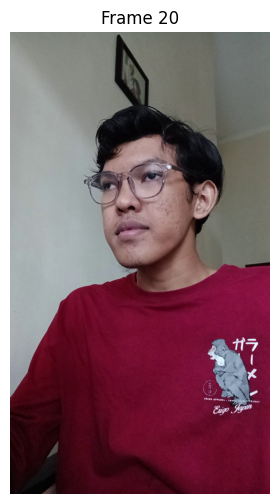

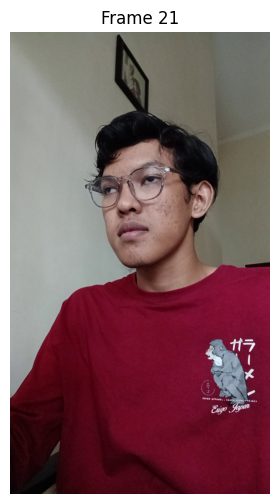

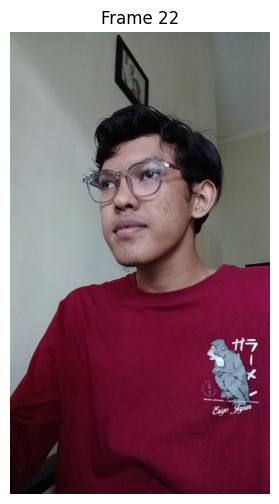

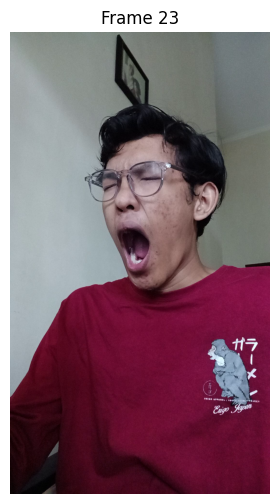

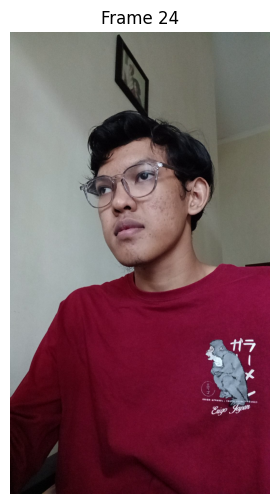

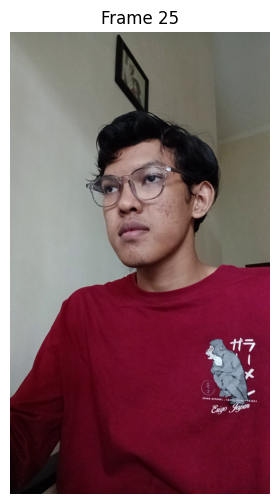

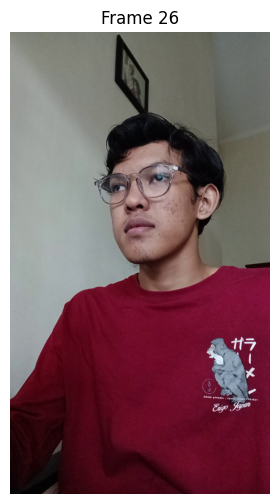

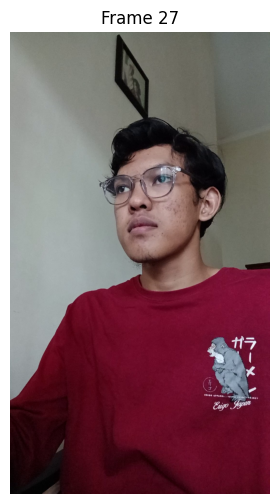

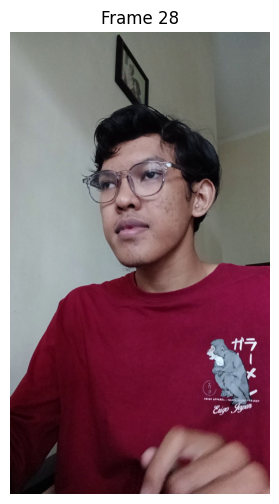

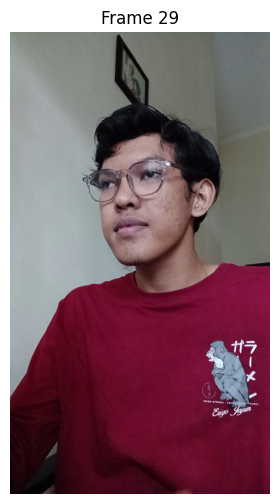

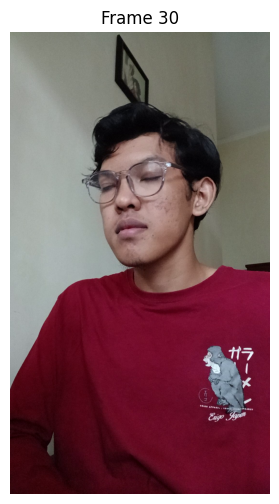

In [26]:
# Path ke video
video_path = 'Dataset\kantuk1.mp4'
video_path = 'Dataset\kantuk2.mp4'

# Membuat folder untuk menyimpan frame jika diperlukan
output_folder = 'Frames\Kantuk'
os.makedirs(output_folder, exist_ok=True)

# Membuka video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Tidak dapat membuka video.")
    exit()

# Daftar untuk menyimpan frame yang diproses
frames = []
frame_count = 0

# Iterasi melalui setiap frame dalam video
while True:
    ret, frame = cap.read()
    if not ret:  # Hentikan jika video selesai
        break

    # Simpan frame dalam list (opsional, tergantung kebutuhan)
    frames.append(frame)

    # Simpan frame ke folder (opsional)
    frame_filename = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)

    frame_count += 1

# Tutup video
cap.release()
print(f"Total frame yang diekstrak: {frame_count}")

# Memilih 10 frame acak untuk ditampilkan
random_frames = random.sample(frames, min(30, len(frames)))

# Menampilkan 10 frame pertama dari yang dipilih
for idx, frame in enumerate(random_frames[:30]):
    # Konversi ke format RGB untuk Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Tampilkan frame
    plt.figure(figsize=(6, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"Frame {idx + 1}")
    plt.show()

### 4.1. Pre-processing: BGR ke Grayscale, HOG Face Detector,

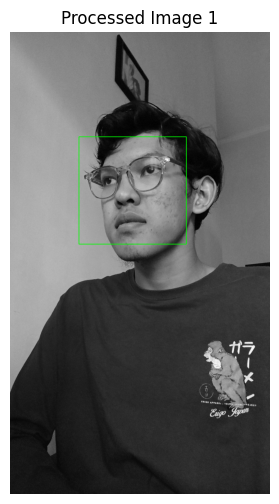

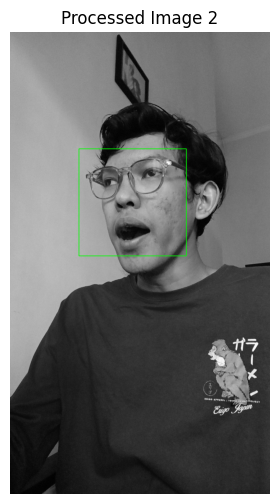

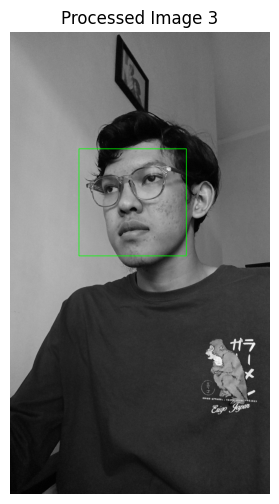

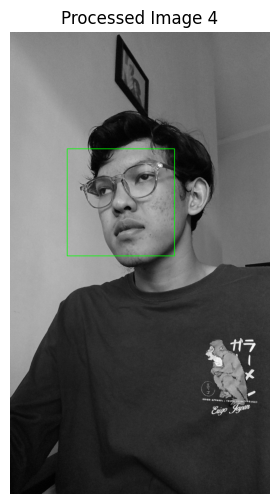

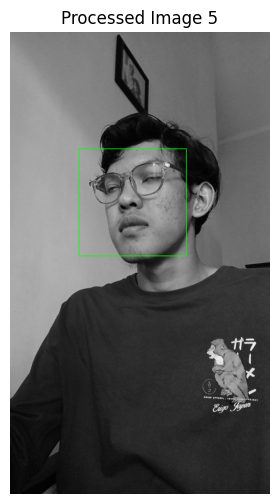

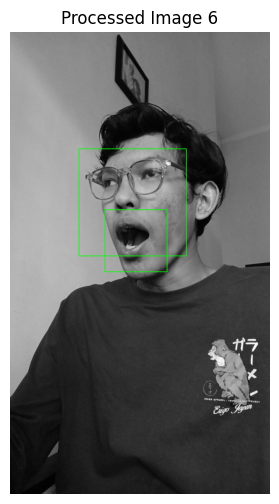

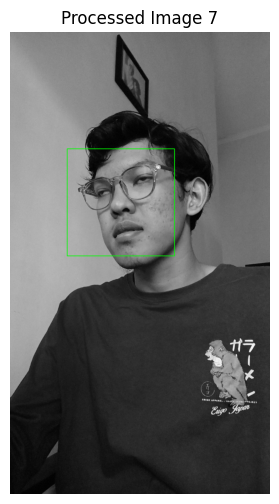

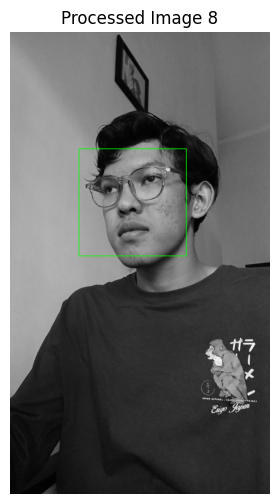

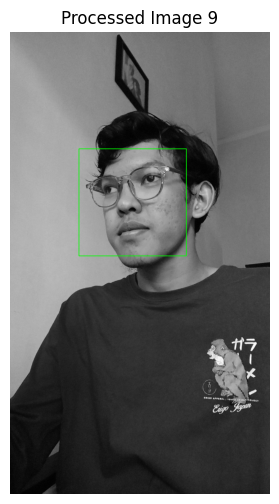

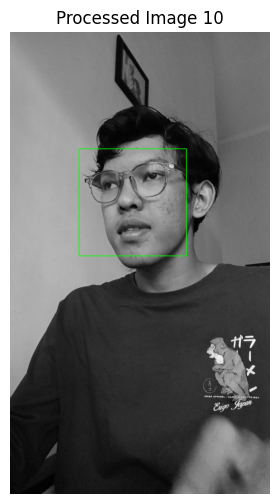

In [27]:
# Inisialisasi detektor wajah HOG
hog_face_detector = dlib.get_frontal_face_detector()

# List untuk menyimpan hasil pre-processing
processed_images = []  # Menyimpan gambar grayscale dengan kotak hijau

# Proses setiap frame secara acak dari random_frames
for frame in random_frames:
    # Konversi ke grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah pada gambar grayscale
    faces = hog_face_detector(gray)

    # Gambarkan kotak di sekitar wajah pada gambar grayscale
    image_with_faces = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Ubah grayscale ke BGR untuk menggambar kotak
    for face in faces:
        x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
        cv2.rectangle(image_with_faces, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Tambahkan hasil akhir ke list
    processed_images.append(image_with_faces)

    # Berhenti setelah memproses 5 gambar (contoh batasan)
    if len(processed_images) == 30:  # Ubah ke 5 untuk pembatasan
        break

# Tampilkan hasil dari array processed_images
for i, img in enumerate(processed_images[:10]):  # Tambahkan slicing [:5] untuk membatasi
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i+1}')
    plt.axis('off')
    plt.show()

In [5]:
%pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


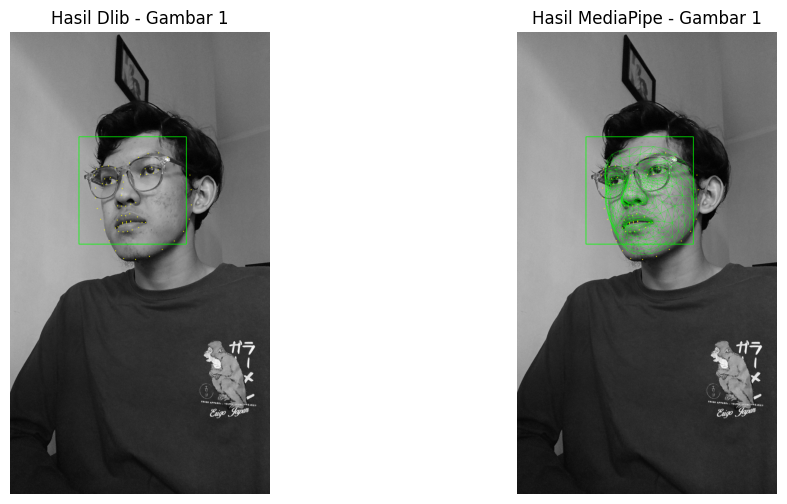

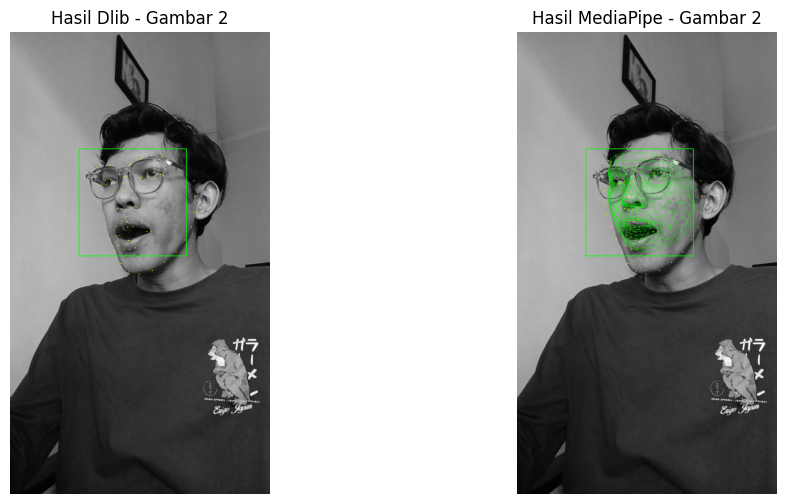

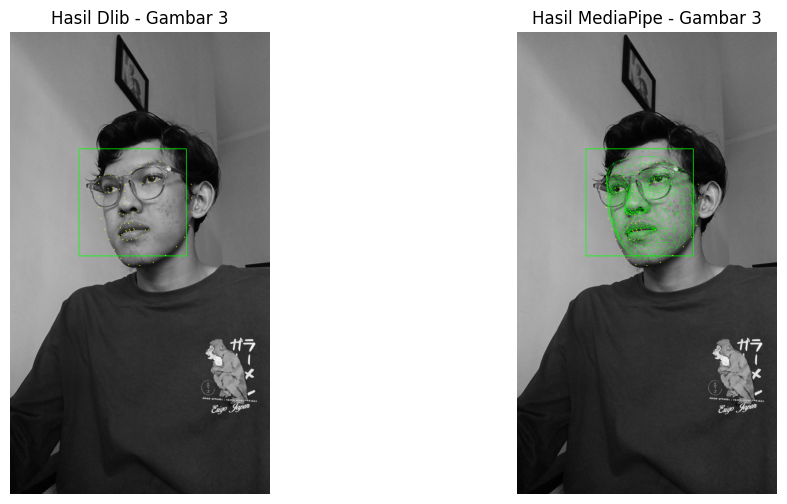

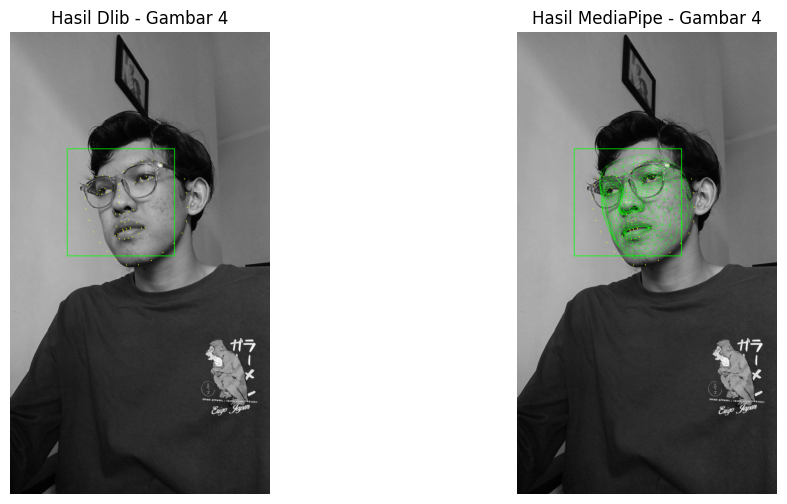

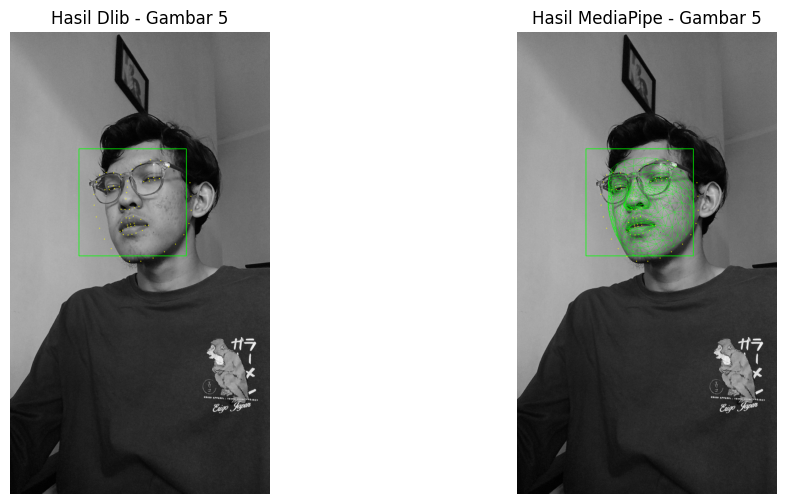

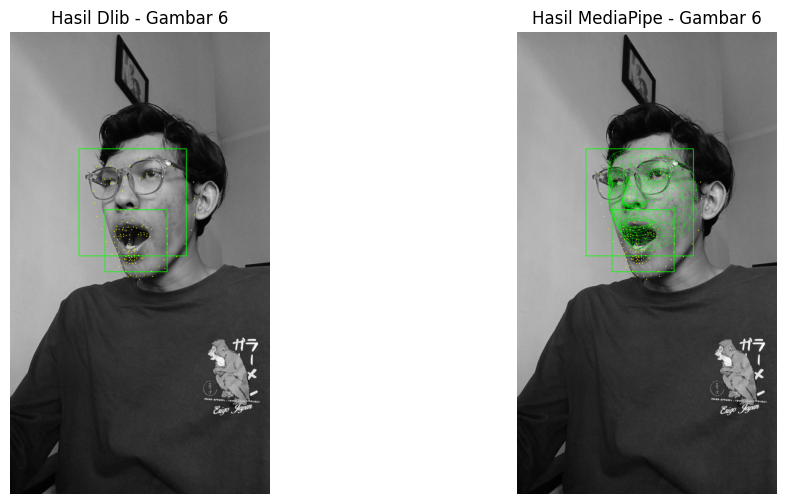

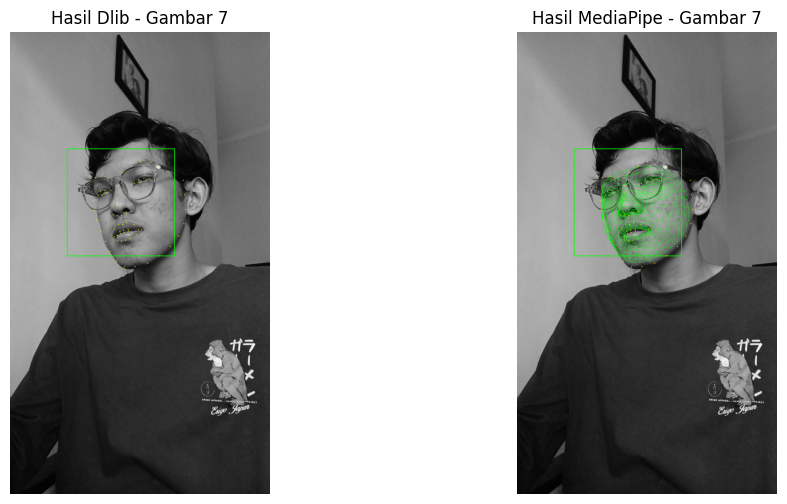

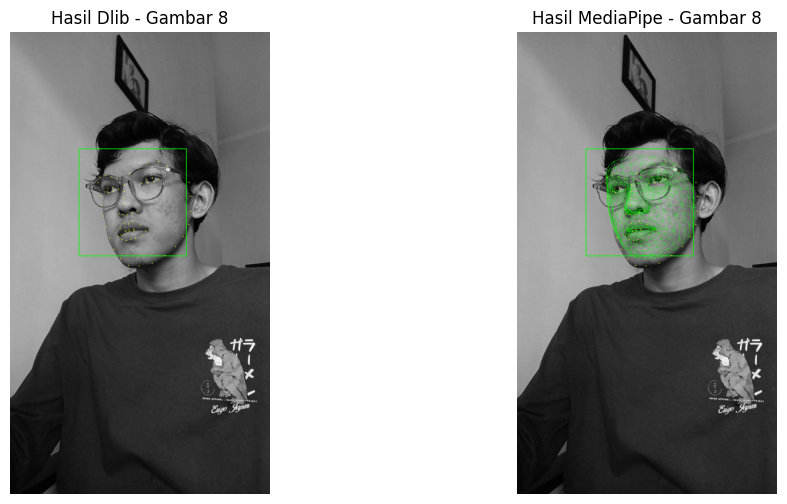

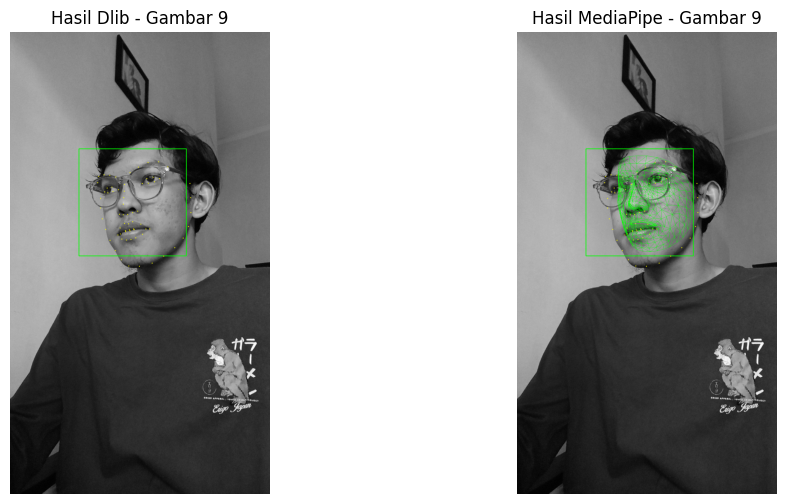

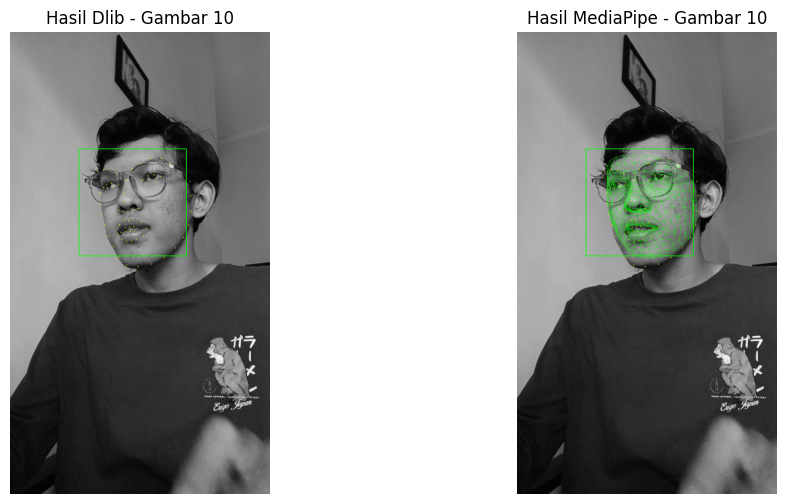

In [28]:
import cv2
import matplotlib.pyplot as plt
import dlib
import mediapipe as mp

# Memuat model Dlib untuk landmark wajah
predictor_path = 'shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
hog_face_detector = dlib.get_frontal_face_detector()  # Inisialisasi HOG face detector

# Inisialisasi MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5
)

# List untuk menyimpan hasil deteksi Dlib
dlib_processed_images = []
# List untuk menyimpan hasil deteksi MediaPipe
mediapipe_processed_images = []

# Proses setiap gambar dalam processed_images
for image in processed_images:  # Menggunakan gambar yang telah diproses sebelumnya
    # Konversi gambar ke grayscale untuk deteksi wajah dengan Dlib
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah dengan Dlib
    faces = hog_face_detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):  # Mengambil 68 titik landmark wajah
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # Menandai titik landmark dengan warna kuning

    # Simpan gambar yang telah diproses oleh Dlib ke dalam list
    dlib_processed_images.append(image)

# Proses gambar-gambar yang telah diproses oleh Dlib dengan MediaPipe
for idx, image in enumerate(dlib_processed_images):
    # Gambar yang telah diproses Dlib digunakan sebagai input untuk MediaPipe
    image_mesh = image.copy()

    # Proses dengan Face Mesh dari MediaPipe
    results = face_mesh.process(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image_mesh,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
            )

    # Simpan gambar hasil deteksi MediaPipe ke dalam list mediapipe_processed_images
    mediapipe_processed_images.append(image_mesh)

for i, (dlib_image, mediapipe_image) in enumerate(zip(dlib_processed_images[:10], mediapipe_processed_images[:10])):
    plt.figure(figsize=(12, 6))

    # Plot hasil Dlib
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(dlib_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil Dlib - Gambar {i + 1}')
    plt.axis('off')

    # Plot hasil MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(mediapipe_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil MediaPipe - Gambar {i + 1}')
    plt.axis('off')


# Ekstraksi Fitur

In [29]:
import numpy as np
from scipy.spatial import distance

# Fungsi untuk menghitung Eye Aspect Ratio (EAR)
def calculate_ear(landmarks):
    # Menghitung jarak antara titik-titik pada mata
    # Mata Kiri
    A1 = distance.euclidean(np.array(landmarks[37]), np.array(landmarks[41]))  # Vertikal
    B1 = distance.euclidean(np.array(landmarks[38]), np.array(landmarks[40]))  # Vertikal
    C1 = distance.euclidean(np.array(landmarks[36]), np.array(landmarks[39]))  # Horizontal

    # Mata Kanan
    A2 = distance.euclidean(np.array(landmarks[43]), np.array(landmarks[47]))  # Vertikal
    B2 = distance.euclidean(np.array(landmarks[44]), np.array(landmarks[46]))  # Vertikal
    C2 = distance.euclidean(np.array(landmarks[42]), np.array(landmarks[45]))  # Horizontal

    # Menghitung EAR untuk kedua mata dan rata-ratanya
    ear_left = (B1 + C1) / (2.0 * A1)
    ear_right = (B2 + C2) / (2.0 * A2)

    ear = (ear_left + ear_right) / 2.0
    return ear

# Fungsi untuk menghitung Mouth Aspect Ratio (MAR)
def calculate_mar(landmarks):
    # Menghitung jarak antara titik-titik pada mulut
    A = distance.euclidean(np.array(landmarks[62]), np.array(landmarks[66]))  # Jarak vertikal
    B = distance.euclidean(np.array(landmarks[61]), np.array(landmarks[67]))  # Jarak horizontal
    C = distance.euclidean(np.array(landmarks[60]), np.array(landmarks[64]))  # Jarak horizontal
    D = distance.euclidean(np.array(landmarks[59]), np.array(landmarks[63]))  # Jarak horizontal

    # Menghitung MAR menggunakan formula
    mar = (B + C + D) / (2.0 * A)
    return mar

In [30]:
# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Cetak hasil per gambar
for result in results:
    print(f"Gambar {result['Gambar']}:")
    print("  Eye Aspect Ratios:", result["EAR"])
    print("  Mouth Aspect Ratios:", result["MAR"])
    print("  Nose X Coordinates:", result["Nose X"])
    print("  Nose Y Coordinates:", result["Nose Y"])

# Cetak hasil akhir untuk semua gambar
print("Hasil Akhir:")
for result in results:
    print(f"Gambar {result['Gambar']}: {result}")

Gambar 1:
  Eye Aspect Ratios: [2.1333672002367914]
  Mouth Aspect Ratios: [10.228899770832495]
  Nose X Coordinates: [465]
  Nose Y Coordinates: [674]
Gambar 2:
  Eye Aspect Ratios: [2.1671190675074543, 2.4712110203718702]
  Mouth Aspect Ratios: [2.4258549271209113, 4.005372758692853]
  Nose X Coordinates: [464, 481]
  Nose Y Coordinates: [684, 853]
Gambar 3:
  Eye Aspect Ratios: [1.980111915734574]
  Mouth Aspect Ratios: [19.064964154434335]
  Nose X Coordinates: [478]
  Nose Y Coordinates: [708]
Gambar 4:
  Eye Aspect Ratios: [2.446096020706814]
  Mouth Aspect Ratios: [8.225188953287873]
  Nose X Coordinates: [456]
  Nose Y Coordinates: [704]
Gambar 5:
  Eye Aspect Ratios: [2.0332002213109144]
  Mouth Aspect Ratios: [5.367737650422015]
  Nose X Coordinates: [484]
  Nose Y Coordinates: [689]
Gambar 6:
  Eye Aspect Ratios: [2.1915799915908405, 2.8594133043920222]
  Mouth Aspect Ratios: [1.871053769632069, 2.6677495635527984]
  Nose X Coordinates: [467, 487]
  Nose Y Coordinates: [688,

In [31]:
import csv
import json

# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR, MAR, dan koordinat hidung ke list
        ear_values.append(ear)
        mar_values.append(mar)
        nose_x_coords.append(landmarks.part(30).x)
        nose_y_coords.append(landmarks.part(30).y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords
    })

# Menyimpan hasil ekstraksi fitur ke dalam file CSV
csv_file_path = 'ekstraksi_fitur.csv'

header = ['Gambar', 'EAR', 'MAR', 'Nose X', 'Nose Y']

# Menulis data ke file CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Menulis header

    for result in results:
        for ear, mar, nose_x, nose_y in zip(result['EAR'], result['MAR'], result['Nose X'], result['Nose Y']):
            writer.writerow([result['Gambar'], ear, mar, nose_x, nose_y])

print(f"Hasil berhasil disimpan dalam {csv_file_path}")

# Menyimpan hasil ekstraksi fitur ke dalam file JSON
json_file_path = 'ekstraksi_fitur.json'

data_to_save = []

for result in results:
    for ear, mar, nose_x, nose_y in zip(result['EAR'], result['MAR'], result['Nose X'], result['Nose Y']):
        data_to_save.append({
            "Gambar": result['Gambar'],
            "EAR": ear,
            "MAR": mar,
            "Nose X": nose_x,
            "Nose Y": nose_y
        })

with open(json_file_path, mode='w') as file:
    json.dump(data_to_save, file, indent=4)

print(f"Hasil berhasil disimpan dalam {json_file_path}")

Hasil berhasil disimpan dalam ekstraksi_fitur.csv
Hasil berhasil disimpan dalam ekstraksi_fitur.json


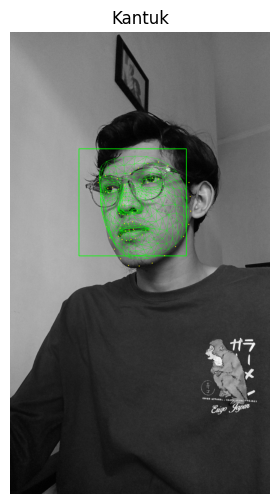


Hasil Ekstraksi Fitur untuk Gambar Kantuk:
  Eye Aspect Ratios (EAR): [2.0332002213109144]
  Mouth Aspect Ratios (MAR): [5.367737650422015]
  Nose X Coordinates: [484]
  Nose Y Coordinates: [689]


In [32]:
import matplotlib.pyplot as plt
import cv2

# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Tampilkan gambar kelima dan hasil ekstraksi fitur dari gambar kelima
if len(mediapipe_processed_images) >= 5:  # Pastikan ada setidaknya 5 gambar
    # Menampilkan gambar kelima
    fifth_image = mediapipe_processed_images[7]  # Gambar kelima (index 4)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(fifth_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Kantuk")
    plt.axis('off')
    plt.show()

    # Menampilkan hasil ekstraksi fitur gambar kelima
    fifth_result = results[4]  # Hasil dari gambar kelima
    print(f"\nHasil Ekstraksi Fitur untuk Gambar Kantuk:")

    if fifth_result["EAR"]:
        print(f"  Eye Aspect Ratios (EAR): {fifth_result['EAR']}")
        print(f"  Mouth Aspect Ratios (MAR): {fifth_result['MAR']}")
        print(f"  Nose X Coordinates: {fifth_result['Nose X']}")
        print(f"  Nose Y Coordinates: {fifth_result['Nose Y']}")
    else:
        print("  Tidak ada wajah yang terdeteksi pada gambar ke tujuh.")
else:
    print("Terdapat kurang dari 10 gambar dalam daftar.")

# Model Random Forest

Memuat dan Menyiapkan data

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import joblib

In [34]:
import pandas as pd

# Membaca data dari file CSV
df = pd.read_csv('ekstraksi_fitur_label.csv')

# Memisahkan fitur dan label
X = df[['EAR', 'MAR', 'Nose X', 'Nose Y']]  # Fitur
y = df['Label']  # Label

Konversi Label ke Angka untuk Random Forest

In [35]:
from sklearn.preprocessing import LabelEncoder

# Mengonversi label menjadi angka
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Mengubah label ke angka

Split Data

In [36]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Latih Model

In [37]:
import pandas as pd
import numpy as np

# Deteksi baris dan kolom dengan nilai inf
inf_indices = np.where(np.isinf(X_train.values))
print("Indeks baris dengan inf:", inf_indices[0])
print("Indeks kolom dengan inf:", inf_indices[1])

# Menampilkan nilai inf di DataFrame
for row, col in zip(inf_indices[0], inf_indices[1]):
    print(f"Nilai inf di baris {row}, kolom {X_train.columns[col]}:", X_train.iloc[row, col])

Indeks baris dengan inf: [226 265 306 311 323 381]
Indeks kolom dengan inf: [1 1 1 1 1 1]
Nilai inf di baris 226, kolom MAR: inf
Nilai inf di baris 265, kolom MAR: inf
Nilai inf di baris 306, kolom MAR: inf
Nilai inf di baris 311, kolom MAR: inf
Nilai inf di baris 323, kolom MAR: inf
Nilai inf di baris 381, kolom MAR: inf


In [38]:
for col in X_train.columns:
    if np.isinf(X_train[col].values).any():
        col_mean = X_train[~np.isinf(X_train[col])][col].mean()
        X_train[col].replace([np.inf, -np.inf], col_mean, inplace=True)

C:\Users\acer\AppData\Local\Temp\ipykernel_9288\1912117157.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].replace([np.inf, -np.inf], col_mean, inplace=True)


In [39]:
# Membuat dan melatih model Random Forest
from sklearn.ensemble import RandomForestClassifier

# Buat model Random Forest dengan pembatasan hyperparameter
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)

Evaluasi Model

In [40]:
# Memprediksi hasil pada data latih
y_pred_train = model.predict(X_train)

# Evaluasi model pada data latih
print("\nEvaluasi pada Data Latih (Training Data):")
print(f"Akurasi pada Data Latih: {accuracy_score(y_train, y_pred_train)}")
print(classification_report(y_train, y_pred_train))


Evaluasi pada Data Latih (Training Data):
Akurasi pada Data Latih: 0.9948320413436692
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       240
           1       1.00      0.99      0.99       147

    accuracy                           0.99       387
   macro avg       1.00      0.99      0.99       387
weighted avg       0.99      0.99      0.99       387



In [41]:
# Memprediksi hasil pada data latih
y_pred_train = model.predict(X_train)

# Evaluasi model pada data latih
print("\nEvaluasi pada Data Latih (Training Data):")
print(f"Akurasi pada Data Latih: {accuracy_score(y_train, y_pred_train)}")
print(classification_report(y_train, y_pred_train))

# Memprediksi hasil pada data uji
y_pred = model.predict(X_test)

# Evaluasi model pada data uji
print(f'Akurasi pada Data Uji: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Evaluasi pada Data Latih (Training Data):
Akurasi pada Data Latih: 0.9948320413436692
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       240
           1       1.00      0.99      0.99       147

    accuracy                           0.99       387
   macro avg       1.00      0.99      0.99       387
weighted avg       0.99      0.99      0.99       387

Akurasi pada Data Uji: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        36

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97



Simpan Model

In [ ]:
import joblib

# Simpan model ke file
joblib.dump(model, 'model_random_forest.pkl')
print("Model berhasil disimpan ke file 'model_random_forest.pkl'")

Model berhasil disimpan ke file 'model_random_forest.pkl'


In [ ]:
print(model)  # Jika model sudah didefinisikan, outputnya akan menampilkan informasi model

RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)
